In [1]:
# =============================================================================
# RQ3: PREDICTIVE MODELING - Concepts vs Mechanisms
# =============================================================================
# Research Questions:
# 1. Can CONCEPTS predict INTEGRITY GROUPS?
# 2. Can MECHANISMS predict INTEGRITY GROUPS?
# 3. Can CONCEPTS predict MECHANISMS?
# =============================================================================

import os, sys, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc
)
from scipy import stats

# -----------------------------------------------------------------------------
# SETUP
# -----------------------------------------------------------------------------
# Setup
os.chdir('game-behavior-analytics/data_analysis_notebook/')
sys.path.append(os.path.abspath('utils'))
warnings.filterwarnings('ignore')

from data_utils import load_and_prepare_data


In [2]:
# -----------------------------------------------------------------------------
# LOAD AND PREPARE DATA
# -----------------------------------------------------------------------------
df, concepts = load_and_prepare_data("data/cheating_experiment_dataset.csv")

print("="*80)
print("RQ3: PREDICTIVE MODELING ANALYSIS")
print("="*80)
print(f"✓ Data loaded: {len(df)} participants")
print(f"✓ Concepts: {len(concepts)} (excluding control)")
print(f"✓ Integrity groups: {df['cheating_behavior'].value_counts().sort_index().to_dict()}")

# -----------------------------------------------------------------------------
# DEFINE MECHANISMS
# -----------------------------------------------------------------------------
mechanisms = [
    'autonomy_need_satisfaction', 'autonomy_need_frustration',
    'competence_need_satisfaction', 'competence_need_frustration',
    'relatedness_need_satisfaction', 'relatedness_need_frustration',
    'cognitive_discomfort', 'moral_disengagement',
    'injunctive_norms', 'descriptive_norms', 'reference_group_identification', 'social_sanctions',
    'performance_accomplishments', 'vicarious_experience', 'verbal_persuasion', 'emotional_arousal'
]

mechanisms = [
    m if m in df.columns else f'perceived_{m}'
    for m in mechanisms if (m in df.columns) or (f'perceived_{m}' in df.columns)
]

df_intervention = df[df['concept'] != 'control'].dropna(subset=mechanisms)
print(f"\n✓ Intervention participants (complete mechanism data): {len(df_intervention)}")
print(f"  Integrity distribution: {df_intervention['cheating_behavior'].value_counts().sort_index().to_dict()}")


RQ3: PREDICTIVE MODELING ANALYSIS
✓ Data loaded: 1232 participants
✓ Concepts: 15 (excluding control)
✓ Integrity groups: {0: 773, 1: 213, 2: 246}

✓ Intervention participants (complete mechanism data): 1159
  Integrity distribution: {0: 734, 1: 203, 2: 222}


In [3]:
# -----------------------------------------------------------------------------
# HELPER FUNCTIONS
# -----------------------------------------------------------------------------
def evaluate_classifier(model, X, y, model_name="Model"):
    """Perform 5-fold CV, train/test split, accuracy, ROC, and report."""
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Cross-validation accuracy
    cv_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    print(f"\n{'='*60}")
    print(f"{model_name} - Cross Validation Results")
    print(f"{'='*60}")
    print(f"Mean CV Accuracy: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")
    print(f"All folds: {[f'{s:.3f}' for s in cv_scores]}")

    # Out-of-sample test accuracy
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    print(f"\nOut-of-sample accuracy (20% hold-out): {test_acc:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=3))

    # ROC Curve (multi-class one-vs-rest)
    y_test_bin = label_binarize(y_test, classes=np.unique(y))
    y_score = model.predict_proba(X_test)

    plt.figure(figsize=(7,6))
    for i, label in enumerate(np.unique(y)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name}')
    plt.legend()
    plt.show()

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return cv_scores.mean(), test_acc


PART 1: Can CONCEPTS predict INTEGRITY GROUPS?
Baseline accuracy (majority class): 0.633

Concepts → Integrity - Cross Validation Results
Mean CV Accuracy: 0.299 (±0.031)
All folds: ['0.306', '0.289', '0.254', '0.349', '0.299']

Out-of-sample accuracy (20% hold-out): 0.284

Classification Report:
              precision    recall  f1-score   support

           0      0.588     0.136     0.221       147
           1      0.224     0.634     0.331        41
           2      0.244     0.455     0.317        44

    accuracy                          0.284       232
   macro avg      0.352     0.408     0.290       232
weighted avg      0.459     0.284     0.259       232



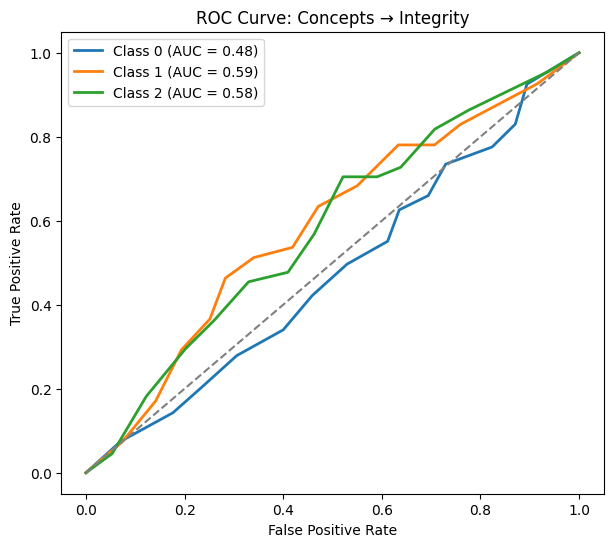

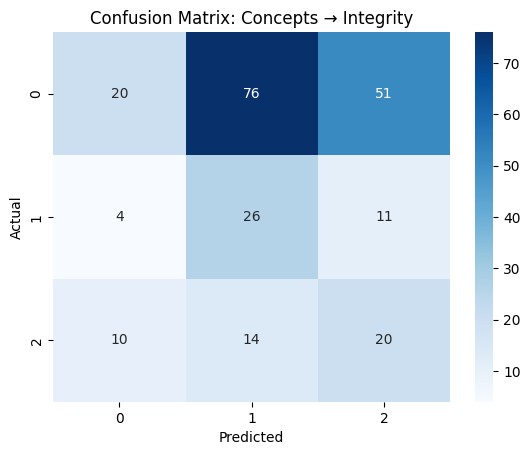

In [4]:
# -----------------------------------------------------------------------------
# PART 1: CONCEPTS → INTEGRITY GROUPS
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("PART 1: Can CONCEPTS predict INTEGRITY GROUPS?")
print("="*80)

X_concepts = pd.get_dummies(df_intervention['concept'], prefix='concept').values
y_integrity = df_intervention['cheating_behavior'].values

baseline_class = stats.mode(y_integrity, keepdims=True)[0][0]
baseline_acc = (y_integrity == baseline_class).mean()
print(f"Baseline accuracy (majority class): {baseline_acc:.3f}")

rf_concepts = RandomForestClassifier(
    n_estimators=500, max_depth=10, min_samples_split=20,
    min_samples_leaf=10, class_weight='balanced', random_state=42, n_jobs=-1
)

cv_concepts, test_concepts = evaluate_classifier(rf_concepts, X_concepts, y_integrity,
                                                 model_name="Concepts → Integrity")


PART 2: Can MECHANISMS predict INTEGRITY GROUPS?

Mechanisms → Integrity - Cross Validation Results
Mean CV Accuracy: 0.491 (±0.033)
All folds: ['0.522', '0.431', '0.483', '0.500', '0.519']

Out-of-sample accuracy (20% hold-out): 0.526

Classification Report:
              precision    recall  f1-score   support

           0      0.676     0.653     0.664       147
           1      0.235     0.098     0.138        41
           2      0.301     0.500     0.376        44

    accuracy                          0.526       232
   macro avg      0.404     0.417     0.393       232
weighted avg      0.527     0.526     0.517       232



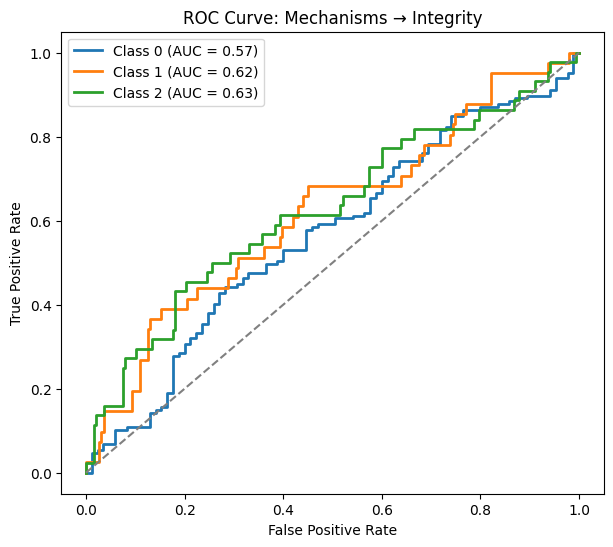

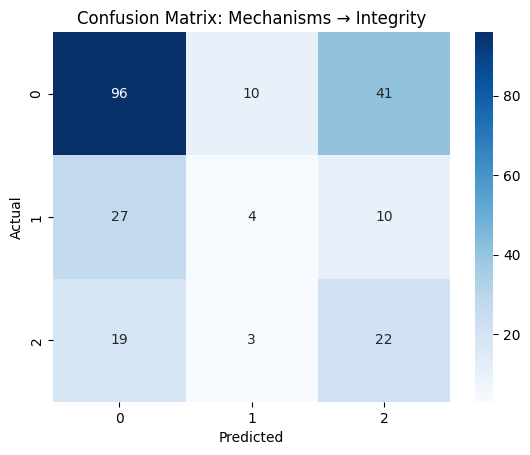


Calculating permutation importance...

Mechanisms with importance:
                     mechanism  importance
 relatedness_need_satisfaction    0.055781
     autonomy_need_frustration    0.047239
             emotional_arousal    0.046333
           moral_disengagement    0.042321
          cognitive_discomfort    0.040984
             verbal_persuasion    0.038525
              injunctive_norms    0.038481
   performance_accomplishments    0.037058
   competence_need_frustration    0.036152
  competence_need_satisfaction    0.034987
              social_sanctions    0.030371
reference_group_identification    0.029638
    autonomy_need_satisfaction    0.029422
  relatedness_need_frustration    0.029163
          vicarious_experience    0.028732
             descriptive_norms    0.020406


In [5]:
# -----------------------------------------------------------------------------
# PART 2: MECHANISMS → INTEGRITY GROUPS
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("PART 2: Can MECHANISMS predict INTEGRITY GROUPS?")
print("="*80)

X_mech = df_intervention[mechanisms].values
X_mech_scaled = StandardScaler().fit_transform(X_mech)

rf_mech = RandomForestClassifier(
    n_estimators=500, max_depth=10, min_samples_split=20,
    min_samples_leaf=10, class_weight='balanced', random_state=42, n_jobs=-1
)

cv_mech, test_mech = evaluate_classifier(rf_mech, X_mech_scaled, y_integrity,
                                         model_name="Mechanisms → Integrity")

# Permutation Importance (post-hoc)
print("\nCalculating permutation importance...")
rf_mech.fit(X_mech_scaled, y_integrity)
perm_importance = permutation_importance(
    rf_mech, X_mech_scaled, y_integrity, n_repeats=20, random_state=42, n_jobs=-1
)
importance_df = pd.DataFrame({
    'mechanism': mechanisms,
    'importance': perm_importance.importances_mean
}).sort_values('importance', ascending=False)
print("\nMechanisms with importance:")
print(importance_df.to_string(index=False))

In [6]:
# -----------------------------------------------------------------------------
# PART 3: CONCEPTS → MECHANISMS
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("PART 3: Can CONCEPTS predict MECHANISMS?")
print("="*80)

r2_results = []
rf_reg = RandomForestRegressor(
    n_estimators=300, max_depth=8, min_samples_split=20,
    min_samples_leaf=10, random_state=42, n_jobs=-1
)

for mech in mechanisms:
    y_mech = df_intervention[mech].values
    scores_r2 = cross_val_score(rf_reg, X_concepts, y_mech, cv=5, scoring='r2')
    r2_results.append({'mechanism': mech.replace('perceived_', ''), 'R2': scores_r2.mean()})

concept_to_mech = pd.DataFrame(r2_results).sort_values('R2', ascending=False)
print("\nSummary: Concepts → Mechanisms (mean cross-validated R²)")
print(concept_to_mech.to_string(index=False))

print(f"\nAverage R² across mechanisms: {concept_to_mech['R2'].mean():.3f}")
print(f"Mechanisms with R² > 0.10:")
print(concept_to_mech[concept_to_mech['R2'] > 0.10].to_string(index=False))


PART 3: Can CONCEPTS predict MECHANISMS?

Summary: Concepts → Mechanisms (mean cross-validated R²)
                     mechanism        R2
             verbal_persuasion -0.007392
  relatedness_need_frustration -0.007624
             emotional_arousal -0.008022
          vicarious_experience -0.010476
 relatedness_need_satisfaction -0.012315
          cognitive_discomfort -0.013474
   performance_accomplishments -0.016378
  competence_need_satisfaction -0.016518
              injunctive_norms -0.016523
              social_sanctions -0.018719
reference_group_identification -0.021185
    autonomy_need_satisfaction -0.022170
             descriptive_norms -0.024871
           moral_disengagement -0.027365
   competence_need_frustration -0.029489
     autonomy_need_frustration -0.034041

Average R² across mechanisms: -0.018
Mechanisms with R² > 0.10:
Empty DataFrame
Columns: [mechanism, R2]
Index: []
